In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA

/home/scrotti/Aptamer2025py/models/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [173]:
import torch
from models.energy_model import EnergyModel

class IndepSites(EnergyModel):
    def __init__(
        self,
        h: torch.Tensor # Lxq tensor
    ):
        super().__init__()
        n_dim = h.dim()
        if n_dim != 2:
            raise ValueError(f"Expected tensor with 2 dimensions, got {n_dim}.")

        self.h = torch.nn.Parameter(h)

    def get_n_states(self):
        return self.h.size(1)

    def get_sequence_length(self):
        return self.h.size(0)

    def compute_energy(
        self,
        x: torch.Tensor
    ):

        L = self.get_sequence_length()
        q = self.get_n_states()
        x_flat = x.view(-1, L * q)
        bias_flat = self.h.view(L * q)

        return - x_flat @ bias_flat

    def forward(self, x):
        return self.compute_energy(x)

    def set_zerosum_gauge(self):
        self.h = self.h - self.h.mean(dim=1, keepdim=True)

In [174]:
import torch
from models.energy_model import EnergyModel

class Potts(EnergyModel):
    def __init__(
        self,
        J: torch.Tensor, # LxqxLxq tensor
        h: torch.Tensor, # Lxq tensor
    ):
        super().__init__()
        sz_h = h.size()
        sz_J = J.size()
        if len(sz_h) != 2:
            raise ValueError(f"Expected tensor with 2 dimensions, got {len(sz_h)}.")
        if len(sz_J) != 4:
            raise ValueError(f"Expected tensor with 2 dimensions, got {len(sz_J)}.")
        if not (sz_J[0:2] == sz_J[2:4] == sz_h):
            raise ValueError("Wrong tensor dimensions")
        
        self.h = torch.nn.Parameter(h)

        L, q = sz_h
        mask = torch.ones(L, q, L, q)
        mask[torch.arange(L), :, torch.arange(L), :] = 0
        # set the (i,i) blocks to zero
        J = J * mask
        self.J = torch.nn.Parameter(J)

    def get_n_states(self):
        return self.h.size(1)

    def get_sequence_length(self):
        return self.h.size(0)

    def compute_energy(
        self,
        x: torch.Tensor
    ):
        L = self.get_sequence_length()
        q = self.get_n_states()
        # the -1 accounts for possible batch index along dimension 0
        x_flat = x.view(-1, L * q)
        bias_flat = self.h.view(L * q)
        couplings_flat = self.J.reshape(L * q, L * q)
        bias_term = x_flat @ bias_flat
        coupling_term = torch.sum(x_flat * (x_flat @ couplings_flat), dim=1)
        return - bias_term - 0.5 * coupling_term

    def forward(self, x):
        return self.compute_energy(x)

    def set_zerosum_gauge(self):
        h = self.h
        self.h = h - h.mean(dim=1, keepdim=True)
        J = self.J
        self.J -= J.mean(dim=1, keepdim=True) + \
                    J.mean(dim=3, keepdim=True) - \
                    J.mean(dim=(1, 3), keepdim=True)    

In [4]:
import torch
from models.energy_model import EnergyModel

# used as dummy for checks
class InfiniteEnergy(EnergyModel):
    def __init__(self):
        super().__init__()

    def compute_energy(
        self,
        x: torch.Tensor
    ):
        if x.dim() == 2:
            return torch.full((1,), torch.inf)
        elif x.dim() == 3:
            return torch.full((x.size(0),), torch.inf)
        else:
            raise ValueError(f"Expected tensor `x` of dimension either 2 or 3, got {x.dim()}")

    def forward(self, x):
        return self.compute_energy(x)

In [175]:
import torch
from models.energy_model import EnergyModel

class GenericEnergyModel(EnergyModel):
    def __init__(
        self,
        model: torch.nn.Module
    ):
        super().__init__()
        self.model = model

    def compute_energy(
        self,
        x: torch.Tensor
    ):
        batch_size, L, q = x.size()
        x_flat = x.view(-1, L * q)

        return self.model(x_flat).squeeze()

    def forward(self, x):
        return self.compute_energy(x)

In [44]:
import torch

class MultiModeDistribution(torch.nn.Module):
    def __init__(
        self,
        *modes,
        normalized: bool = True
    ):
        super().__init__()
        self.modes = torch.nn.ModuleList(modes)
        self.normalized = normalized

    def get_n_modes(self):
        return len(self.modes)

    def compute_logprobabilities(
        self,
        x: torch.Tensor,  # batch_size * L * q
    ) -> torch.Tensor: # batch_size * n_modes
        minusE = torch.Tensor()
        for mode in self.modes:
            minusEw = - mode.compute_energy(x)
            minusE = torch.cat((minusE, minusEw[:,None]), dim=1)
        logp = minusE 
        if self.normalized == True:
            logp = logp - minusE.logsumexp(dim=1, keepdim=True)
        return logp    

In [45]:
import torch

def store_ancestors(parent):
    N = parent.size(0)

    ancestors = []
    offset = torch.zeros(N, dtype=torch.long)
    length = torch.zeros(N, dtype=torch.long)

    cur_offset = 0

    for v in range(N):
        path = [v]
        p = parent[v]

        while p != -1:
            path.append(p)
            p = parent[p]

        offset[v] = cur_offset
        length[v] = len(path)
        ancestors.extend(path)
        cur_offset += len(path)

    ancestors_flat = torch.tensor(ancestors, dtype=torch.long)
    return ancestors_flat, offset, length

def ancestors_of(v, ancestors_flat, offset, length):
    return ancestors_flat[offset[v] : offset[v] + length[v]]


class Tree:
    def __init__(self,
                 parent: torch.Tensor | None = None,  # parent[v] is the index of v's parent. the root is -1
                 nodename = None, 
                ):
        if parent is None:
            parent = torch.IntTensor()
            
        assert((parent >= -1).all())
        if nodename is None:
            nodename = [str(v) for v in range(len(parent))]
        assert(len(nodename) == parent.size(0))
        self.parent = parent
        self.nodename = nodename
        self.ancestors_flat, self.offset, self.length = store_ancestors(parent)

    def ancestors_of(self, v):  # returns a torch vector with v and its ancestors
        assert(v < self.get_n_nodes()), f"v={v}"
        return self.ancestors_flat[self.offset[v] : self.offset[v] + self.length[v]]

    def get_n_nodes(self):   # excluding the root
        return len(self.parent)

    def get_depth(self):
        return self.length.max().item()

    def parent(self, v):
        assert(v < self.get_n_nodes())
        return self.parent[v]

    def add_node(self, parent_node, name = None):
        N = self.get_n_nodes
        if name is None:
            name = str(N)
        if type(parent_node) is str:
            if parent_node == "root":
                parent_node = -1
            else:
                parent_node = self.nodename.index(parent_node)
            
        self.parent = torch.cat((self.parent, torch.IntTensor([parent_node])))
        self.nodename.append(name)
        self.ancestors_flat, self.offset, self.length = store_ancestors(self.parent)  # re-computing everything, not efficient but ok  
        

class RoundTree:
    def __init__(
        self,
        n_modes: int | None = None,
        tree: Tree | None = None,  
        selected_modes: torch.BoolTensor | None = None,   # (n_rounds * n_modes) modes selected for at each round
    ):
        if n_modes is None:
            if selected_modes is None:
                raise ValueError("Must provide either the selected modes or the total number of modes")
            else:
                n_modes = selected_modes.size(1)
        if tree is None:
            tree = Tree()
        if selected_modes is None:
            selected_modes = torch.BoolTensor()
        elif not (selected_modes.sum(dim=1) > 0).all():
            raise ValueError("At least one mode must be selected")
            
        n_rounds = tree.parent.size(0)
        assert(selected_modes.size(0) == n_rounds)

        self.n_modes = n_modes
        self.tree = tree
        self.selected_modes = selected_modes   

    def add_node(self, parent_node, selected_modes, name = None):
        assert selected_modes.size(0) == self.n_modes, f"Number of modes in `selected_modes`, {selected_modes.size(0)}, different from the expected {self.n_modes}"
        assert selected_modes.sum() > 0, f"At least one mode must be selected"
        self.tree.add_node(parent_node, name=name)
        self.selected_modes = torch.cat((self.selected_modes, selected_modes[None,:]))

    def parent(self, t):
        return self.tree.parent(t)

    def ancestors_of(self, v):
        return self.tree.ancestors_of(v)

    def get_n_modes(self):
        return self.n_modes

In [46]:
import torch

class MultiRoundDistribution(torch.nn.Module):
     def __init__(
        self,
        round_zero: EnergyModel,
        selection: MultiModeDistribution,
        round_tree: RoundTree
     ):
        if selection.get_n_modes() != round_tree.get_n_modes():
            raise ValueError(f"Number of modes must coincide for selection probability, got {selection.get_n_modes()} and {round_tree.get_n_modes()}")
        super().__init__()
        self.round_zero = round_zero
        self.selection = selection
        self.round_tree = round_tree

     # compute $\sum_{\tau \in \mathcal A(t)} \log p_{s,\tau}
     def selection_energy_up_to_round(self, x, t):
        if t == -1:
            return torch.zeros(x.size(0))
        ancestors = self.round_tree.ancestors_of(t)
        logps_modes = self.selection.compute_logprobabilities(x)
        ancestors = self.round_tree.ancestors_of(t)
        selected = self.round_tree.selected_modes[ancestors]
        # first pick only the selected rounds, then (log)sum(exp) over modes, then sum over rounds
        return - (logps_modes[:,None,:] + torch.log(selected)).logsumexp(dim=-1).sum(1)

     # compute sum_tau log p_{s,tau}
     # @torch.compile
     def compute_energy_up_to_round(self, x, t):
         logNs0 = - self.round_zero.compute_energy(x)
         logps = - self.selection_energy_up_to_round(x, t)
         return - (logps + logNs0)

In [47]:
round_tree = RoundTree(n_modes=3)
round_tree.add_node(-1, torch.BoolTensor([1, 0, 1]))
round_tree.add_node(0, torch.BoolTensor([1, 1, 0]))
round_tree.add_node(-1, torch.BoolTensor([0, 0, 1]))

round_tree.selected_modes

tensor([[ True, False,  True],
        [ True,  True, False],
        [False, False,  True]])

In [48]:
q = 4
L = 20

k = torch.randn(L, q)

n_modes = 3
potts_models = [
    Potts(torch.randn(L, q, L, q), torch.randn(L, q))
          for _ in range(n_modes)]

Ns0 = IndepSites(k)
ps = MultiModeDistribution(*potts_models)
Nst = MultiRoundDistribution(Ns0, ps, round_tree)

In [49]:
from adabmDCA.functional import one_hot
M = 5
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [50]:
t = 2
en = Nst.compute_energy_up_to_round(x, t)
avg_en = en.mean()
avg_en.backward()

In [51]:
def perceptron(L):
    return torch.nn.Sequential(
        torch.nn.Linear(L*q, 1),
        torch.torch.nn.Softmax(dim=0)
    )

nns = [GenericEnergyModel(perceptron(L)) for _ in range(n_modes)]
ps = MultiModeDistribution(*nns)
Nst = MultiRoundDistribution(Ns0, ps, round_tree)

In [52]:
nn = GenericEnergyModel(perceptron(L))
nn.compute_energy(x)

tensor([0.2016, 0.1905, 0.2342, 0.1694, 0.2043], grad_fn=<SqueezeBackward0>)

In [53]:
IndepSites(torch.randn(L, q)).compute_energy(x)

tensor([ 1.1230, -4.0795, -5.4638, -2.5009,  1.3810], grad_fn=<MvBackward0>)

In [54]:
en = Nst.compute_energy_up_to_round(x, 1)
avg_en = en.mean()
avg_en.backward()

In [55]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

round_tree = RoundTree(n_modes=2)
round_tree.add_node(-1, torch.BoolTensor([1, 0]))
round_tree.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = IndepSites(k)
potts = Potts(J, h)
ps = MultiModeDistribution(potts, InfiniteEnergy(), normalized=False)
Nst = MultiRoundDistribution(Ns0, ps, round_tree)

M = 30
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [56]:
params = {"bias_Ns0": k, "bias_ps": h, "couplings_ps": potts.J}

for t in range(2):
    params_t = selex_dca.get_params_at_round(params, t)
    en_adabm = adabmDCA.statmech.compute_energy(x, params_t)
    en_class = Nst.compute_energy_up_to_round(x, t-1)
    assert torch.allclose(en_adabm, en_class)

In [269]:
@torch.compile
def metropolis_step_uniform_sites(
    chains: torch.Tensor,
    compute_energy,
    beta: float = 1.0
    # random number generator!
):
    energy_curr = compute_energy(chains)
    device = chains.device
    dtype = chains.dtype
    n_chains, L, q = chains.shape
    idx = torch.randint(0, L, (1,), device=chains.device)[0]
    res_curr = chains[:, idx, :]
    # Propose a random new residue
    res_new = one_hot(torch.randint(0, q, (n_chains,), device=chains.device), num_classes=q).to(dtype)
    chains_new = chains.clone()
    idx_expanded = idx.view(1, 1, 1).expand(n_chains, 1, q)
    chains_new.scatter_(1, idx_expanded, res_new.unsqueeze(1))
    energy_new = compute_energy(chains_new) # shape (n_chains,)
    delta_energy = energy_new - energy_curr
    accept_prob = torch.exp(- beta * delta_energy).unsqueeze(-1)
    accepted = accept_prob > torch.rand((n_chains, 1), device=device, dtype=dtype)
    return torch.where(accepted.unsqueeze(-1), chains_new, chains)
    # TODO: use randexp

def sample_metropolis_uniform_sites(
    chains: torch.Tensor,
    compute_energy,
    n_sweeps: int,
    beta: float = 1.0,
    # random number generator!
):
    n_chains, L, q = chains.size()
    n_steps = n_chains * L
    with torch.no_grad():
        for step in torch.arange(n_steps):
            chains = metropolis_step_uniform_sites(chains, compute_energy, beta)
    return chains

In [270]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

round_tree = RoundTree(n_modes=2)
round_tree.add_node(-1, torch.BoolTensor([1, 0]))
round_tree.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = IndepSites(k)
potts = Potts(J, h)
ps = MultiModeDistribution(potts, InfiniteEnergy(), normalized=False)
Nst = MultiRoundDistribution(Ns0, ps, round_tree)

M = 10
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [278]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, 0)

chains = metropolis_step_uniform_sites(chains, compute_energy)
chains = sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [279]:
from tqdm import tqdm
    
energies = [compute_energy(chains).mean().detach().numpy()]
N = 100
for i_ in tqdm(range(N)):
    chains = sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=5.0)
    energies.append(compute_energy(chains).mean().detach().numpy())

100%|███████████████████| 100/100 [00:12<00:00,  8.21it/s]


In [273]:
marginals = torch.exp(Ns0.h)
marginals = marginals / marginals.sum(dim=1, keepdim=True)
avg_en = (- Ns0.h * marginals).sum(dim=1).sum(dim=0)

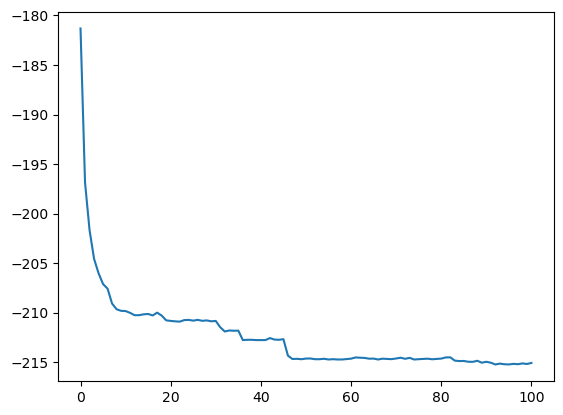

In [280]:
import matplotlib.pyplot as plt
plt.plot(energies)
# plt.axhline(y=avg_en.detach().numpy(), color='r')

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import torch
from torch.utils.data import Dataset

class SelexRoundDataset(Dataset):
    def __init__(
        self, 
        seq_oh: torch.Tensor  # n_seq * L * q
    ):
        self.super().__init__()
        assert seq_oh.dim == 3
        self.seq_oh = seq_oh

    def __len__(self):
        return self.seq_oh.shape[0]

    def __get__item(self, idx):
        return self.seq_oh[idx]

In [ ]:
class SelexRoundDataLoader(DataLoader):
    